In [350]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow import keras
import numpy as np
import pandas as pd
import os
plt.rcParams['figure.figsize'] = (10, 10)

#### Instantiate the model

In [351]:
vgg_model = keras.applications.vgg16.VGG16(weights='imagenet')

#### Summary

In [352]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [353]:
vgg_model.layers

Plot some filters from the first convolutional layer

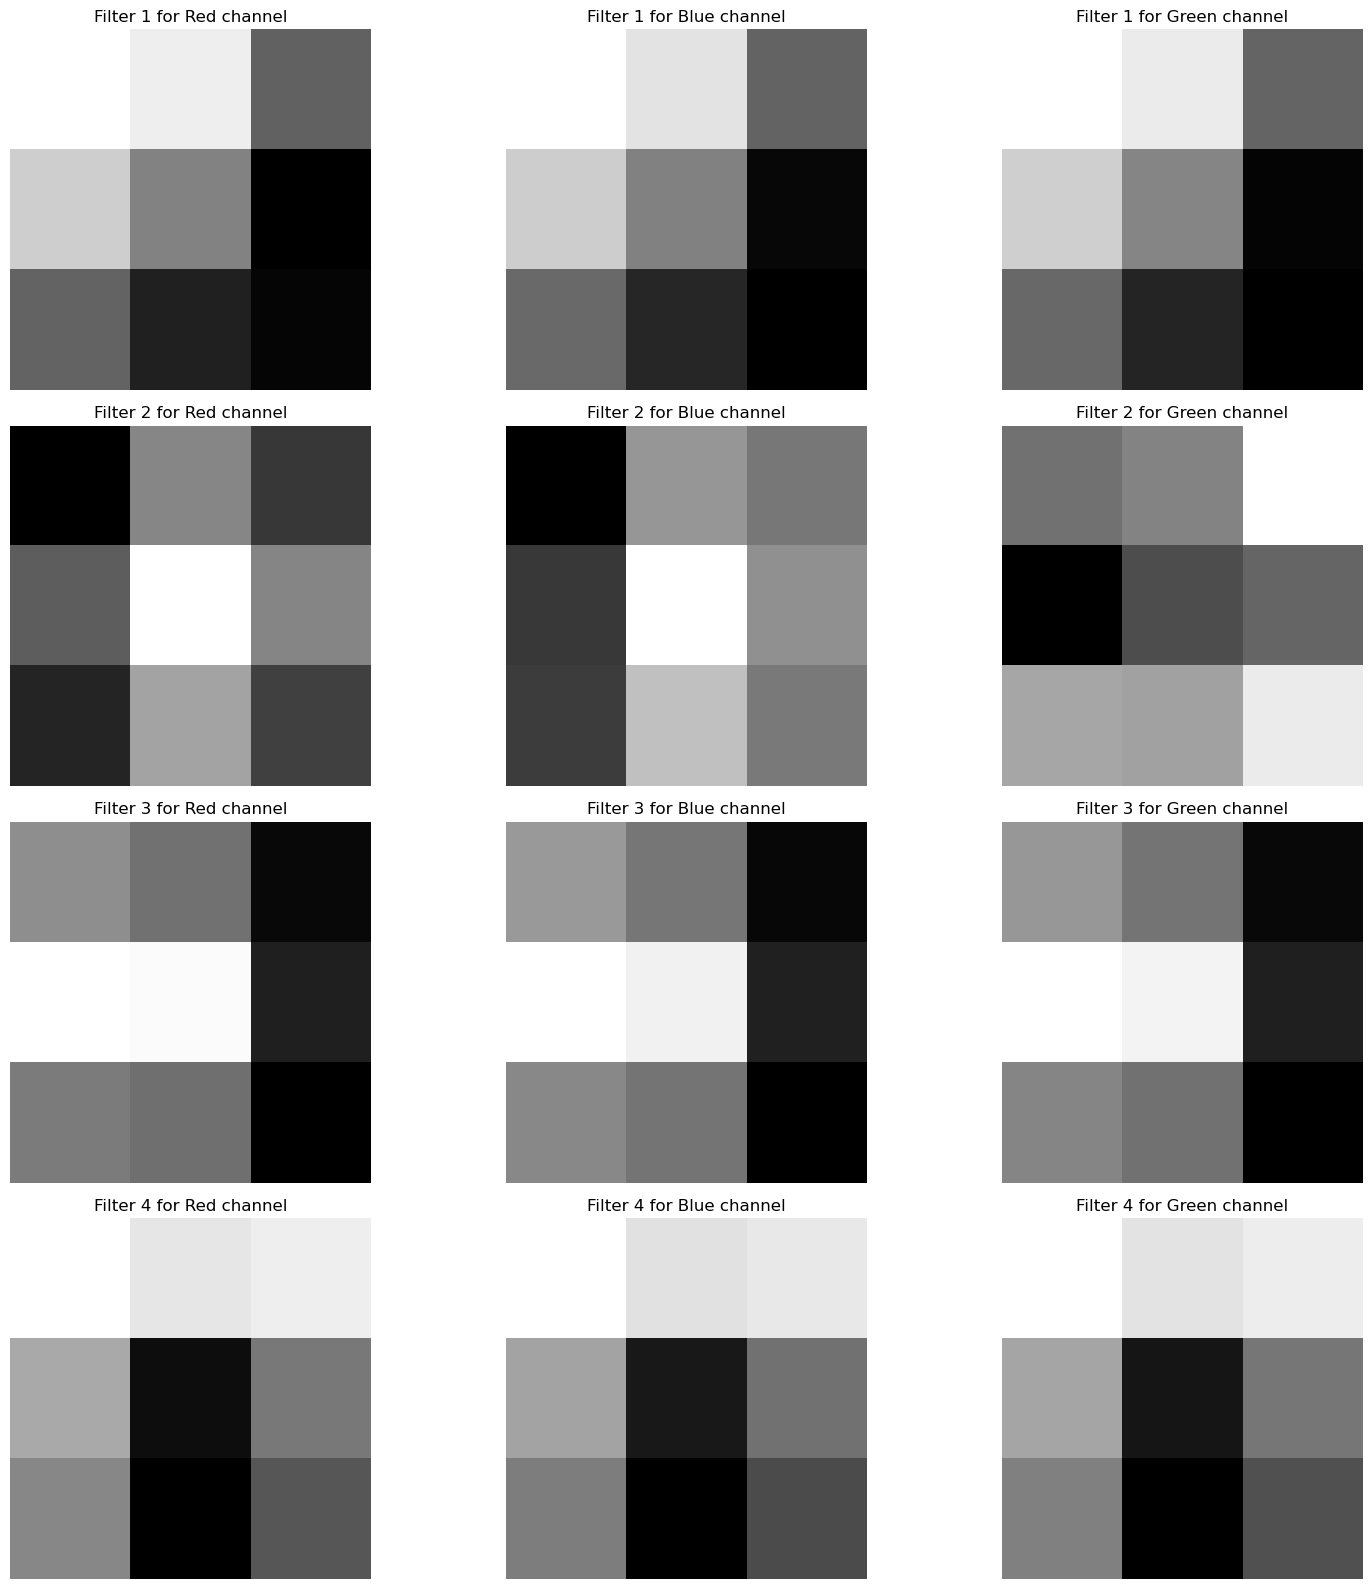

In [354]:
filters, biases = vgg_model.layers[1].get_weights()

n_filters= 4
ix = 1
plt.figure(figsize=(16,16))

for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    
    # plot each channel separately
    for j in range(3):
    
    # specify subplot and turn off axis
        if j == 0 :
            plt.subplot(n_filters, 3, ix,title= f'Filter {i+1} for Red channel')
            plt.imshow(f[:, :, j],cmap="gray")
        if j == 1 :
            plt.subplot(n_filters, 3, ix,title= f'Filter {i+1} for Blue channel')
            plt.imshow(f[:, :, j],cmap="gray")
        if j == 2 :
            plt.subplot(n_filters, 3, ix,title= f'Filter {i+1} for Green channel')
            plt.imshow(f[:, :, j],cmap="gray")
        ix += 1
        plt.axis('off')
plt.tight_layout()


#### Create a base model 
We exclude the top part, referring to the classification layers.
Doing so our model is capable of extracting features.

In [355]:
base_model = keras.applications.vgg16.VGG16(
    weights='imagenet',input_shape=(224,224,3),
    include_top=False)

In [356]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [357]:
base_model.layers

#### Freeze all the Conv block 

In [358]:
for layers in base_model.layers[:]: 
    layers.trainable = False # --> all layers frozen means they are not trainable

In [359]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [360]:
#to unfreeze some layers
#unfreeze_layers = 5
#for layers in base_model.layers[-unfreeze_layers:]: # --> last 5 layers trainable
    #layers.trainable = True

## Load the data 

In [361]:
# Let's explore the data folder
base_path = './../../../../week09/imageclassifier/image_pen-eraser/'

# Let's define the classes
classes = os.listdir(base_path)

In [362]:
classes

['.DS_Store', 'eraser', 'pen', 'scissors']

In [363]:
def load_image(base_path):
    """it loads all the image into X and the classes in y """
    X_list = []
    y_list = []
    classes = os.listdir(base_path)
    for class_ in classes:
        if not class_.endswith('.DS_Store'):       
            files = os.listdir(base_path+class_)
            #print(files)
            for file in files:
                if not file.endswith('.DS_Store'): 
                    pic = keras.preprocessing.image.load_img(path=base_path+class_+'/'+f'{file}',target_size=(224,224))
                    numpy_image = np.array(pic)
                    processed_image = preprocess_input(numpy_image)
                    X_list.append(processed_image)
                    y_list.append(class_)
        
    X = np.array(X_list)
    y = np.array(y_list)
    
    # shuffle the data
    shuffler = np.random.permutation(len(X))
    X = X[shuffler]
    y = y[shuffler]
    
    return X, y, classes

In [364]:
X,y,classes= load_image(base_path)

In [365]:
X.shape

(105, 224, 224, 3)

In [366]:
classes=['eraser', 'pen', 'scissors']

In [367]:
classes

['eraser', 'pen', 'scissors']

In [368]:
y

array(['eraser', 'scissors', 'eraser', 'pen', 'scissors', 'eraser', 'pen',
       'eraser', 'pen', 'scissors', 'eraser', 'scissors', 'scissors',
       'eraser', 'pen', 'eraser', 'eraser', 'pen', 'pen', 'scissors',
       'eraser', 'scissors', 'pen', 'eraser', 'pen', 'eraser', 'pen',
       'scissors', 'pen', 'pen', 'scissors', 'eraser', 'eraser', 'eraser',
       'scissors', 'eraser', 'eraser', 'scissors', 'eraser', 'scissors',
       'pen', 'pen', 'pen', 'eraser', 'pen', 'eraser', 'eraser', 'pen',
       'eraser', 'eraser', 'pen', 'scissors', 'scissors', 'scissors',
       'pen', 'eraser', 'pen', 'scissors', 'pen', 'pen', 'scissors',
       'pen', 'pen', 'eraser', 'eraser', 'pen', 'pen', 'pen', 'scissors',
       'scissors', 'scissors', 'scissors', 'eraser', 'pen', 'scissors',
       'scissors', 'pen', 'scissors', 'eraser', 'scissors', 'eraser',
       'pen', 'scissors', 'scissors', 'pen', 'scissors', 'eraser',
       'scissors', 'scissors', 'scissors', 'eraser', 'eraser', 'pen',
   

In [369]:
# y to categorical
y_series = pd.Series(y).map({classes[0]:0, classes[1]:1, classes[2]:2})
y = to_categorical(y_series)


In [370]:
y

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1

## Base Model + Output Layer and/or Customed Dense Layers for Classification

+ fc1 with 100 neurons and activation relu
+ fc2 with 100 neurons and activation relu
+ prediction with 2 neurons for classification

### Configure the model

In [371]:
from tensorflow.keras import backend as K

In [372]:
K.clear_session()
new_model = keras.models.Sequential([
    
    # Base model
    base_model,
    
    # Flatten layer
    keras.layers.Flatten(),
    
    #keras.layers.Dropout(.5),
    # fc1 fully connected layer
    #keras.layers.Dense(units=100, activation=keras.activations.relu, name='fc1'),
    
    # fc2 fully connected layer
    #keras.layers.Dense(units=100, activation=keras.activations.relu, name='fc2'),
    
    # output layer
    keras.layers.Dense(units=3, activation=keras.activations.softmax, name='otput')

])

In [373]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 otput (Dense)               (None, 3)                 75267     
                                                                 
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________


### Compile the new model

In [374]:
new_model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(learning_rate=0.008),
                 metrics=keras.metrics.CategoricalAccuracy())

### Fit the new model

In [375]:
#tf.debugging.set_log_device_placement(True)

history = new_model.fit(X,y,batch_size=20, epochs=10, validation_split=.2)

Epoch 1/10
5/5 [==============================] - 36s 7s/step - loss: 31.3139 - categorical_accuracy: 0.6429 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 2/10
5/5 [==============================] - 29s 6s/step - loss: 1.9470 - categorical_accuracy: 0.9762 - val_loss: 14.7077 - val_categorical_accuracy: 0.8571
Epoch 3/10
5/5 [==============================] - 29s 6s/step - loss: 2.9292 - categorical_accuracy: 0.9524 - val_loss: 4.8251e-07 - val_categorical_accuracy: 1.0000
Epoch 4/10
5/5 [==============================] - 29s 6s/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 3.2853 - val_categorical_accuracy: 0.9524
Epoch 5/10
5/5 [==============================] - 31s 6s/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 6.8393 - val_categorical_accuracy: 0.9524
Epoch 6/10
5/5 [==============================] - 31s 6s/step - loss: 4.1581e-07 - categorical_accuracy: 1.0000 - val_loss: 9.0322 - val_categorical_accuracy: 0.9524
Epoch 

### Plot the results

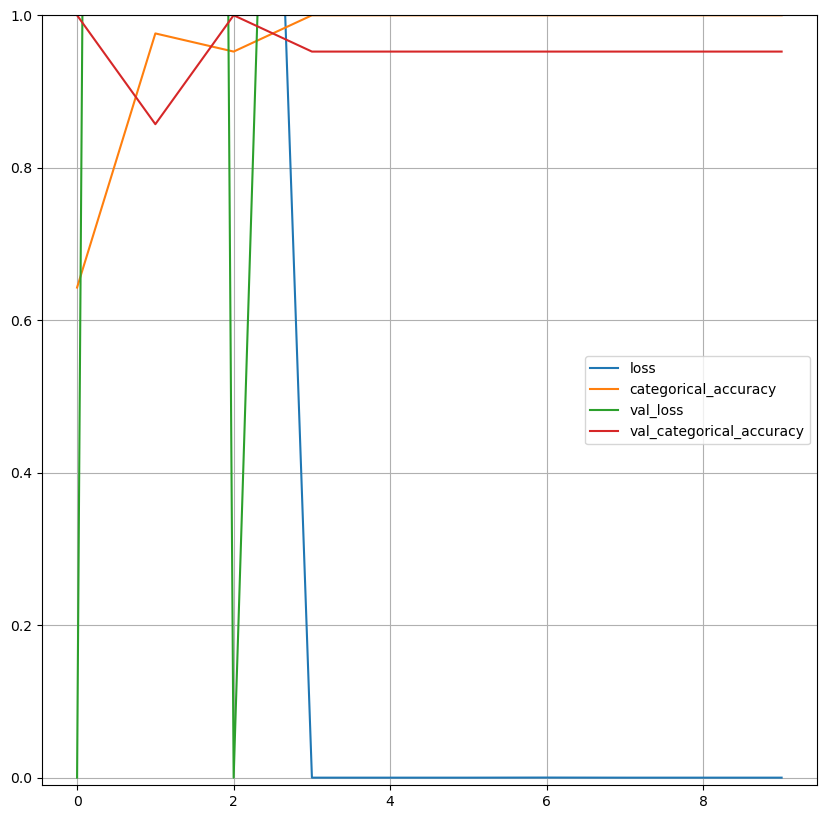

In [376]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.01,1)
plt.savefig('conv_frozen_new_fcl.png')

## Predict

### Let's use this for many images 

In [377]:

base_path = './../../../../week09/imageclassifier/test/'
files = []
for file in os.listdir(path=base_path):
    if file != ".DS_Store":
        files.append(file)
files


['16-24-22-163147.png', '17-15-11-233435.png', '16-24-27-799793.png']

1/1 [==============================] - 1s 569ms/step


'./../../../../week09/imageclassifier/test/16-24-27-799793.png'

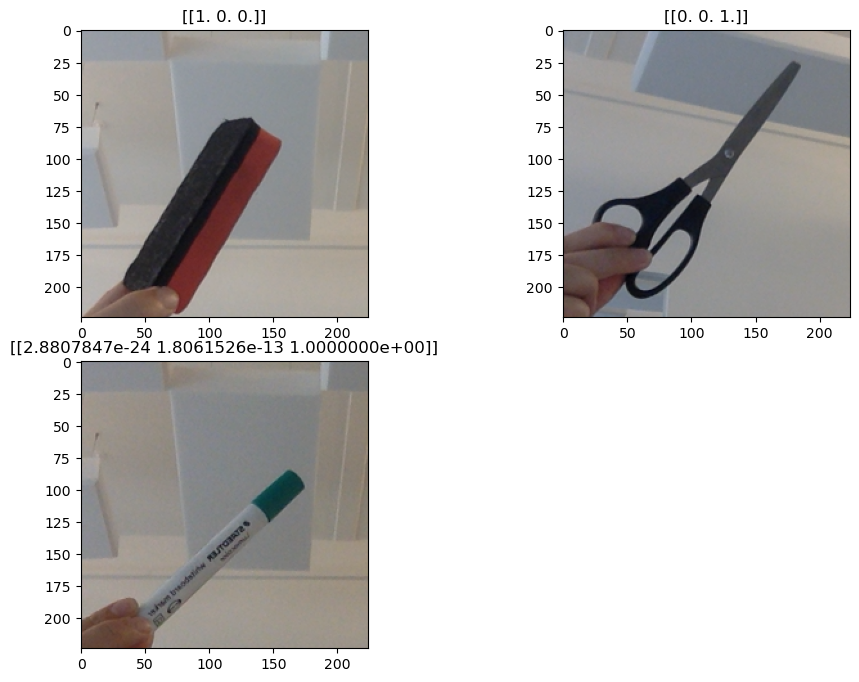

In [378]:
def batch_prediction(files = files):

    for i in range(len(files)):
        
        """read and preprocess"""
        my_path = f"{base_path}{files[i]}"
        pic = keras.preprocessing.image.load_img(my_path,target_size=(224,224)) #load image
        numpy_image = np.array(pic) # from image to numpy array
        image_batch = np.expand_dims(numpy_image, axis=0) #add 1 dimention
        processed_image = keras.applications.vgg16.preprocess_input(image_batch) #preprocess image
        
        """predict"""
        predictions = new_model.predict(processed_image) # prediction
#        label_vgg = keras.applications.imagenet_utils.decode_predictions( predictions) #extract label

        """plot"""
        plt.subplot(3,2,i+1);
        plt.tight_layout()
        plt.imshow(pic)
        plt.title(f'{predictions}' )
    return my_path
    

batch_prediction()